# Verbatim compilation

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

Usually, when you run a circuit on a QPU, behind the scenes, Amazon Braket will do a series of compilation steps to optimize your circuit and map the abstract circuit to the physical qubits on the QPU. However, in many situations,  such as for error mitigation or benchmarking experiments, researchers require full control of the qubits and the gates that are being applied. In a [previous notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Allocating_Qubits_on_QPU_Devices.ipynb), we showed you how to manually allocate the qubits of your circuit, i.e., how you can exactly define which logical qubit maps to which physical qubit. In this notebook, you will learn how to use _verbatim compilation_ to run your circuits exactly as defined without any modification during the compilation process.

### Table of contents:

* [Recap: Running circuits on Amazon Braket](#Recap)
* [Using verbatim compilation to run circuits without further compilation](#Verbatim)
* [Programming verbatim circuits onto the Rigetti device](#Rigetti)

## Recap: Running circuits on Amazon Braket  <a class="anchor" id="Recap"></a>

Let us begin with importing the usual dependencies. Verbatim compilation is supported by all Rigetti devices, and we will use the Ankaa-2 device for this demonstration.

In [2]:
# general imports
from math import pi

import networkx as nx

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import Devices

%matplotlib inline

When you run a circuit on Amazon Braket, different compilation and optimization steps occur before the circuit is executed on the selected QPU. First, the gates of your circuit are decomposed into the _native gates_ of the QPU. Let's first remember what the native gates of the Ankaa-2 device are:

In [3]:
# set up the Rigetti Ankaa-2 device
device = AwsDevice(Devices.Rigetti.Ankaa2)

# list the native gate set
print("The native gates for the", device.name, "device are:")
for gate in device.properties.paradigm.nativeGateSet:
    print(gate)

The native gates for the Ankaa-2 device are:
rx
rz
cz
iswap


If we create a circuit with gates that are not part of that list, the gates will automatically be decomposed into a gate set that can be executed on the device.

In [4]:
bell = Circuit().h(0).cnot(0, 1)
print(bell)
result = device.run(bell, shots=1000).result()
print(result.measurement_counts)

T  : │  0  │  1  │
      ┌───┐       
q0 : ─┤ H ├───●───
      └───┘   │   
            ┌─┴─┐ 
q1 : ───────┤ X ├─
            └───┘ 
T  : │  0  │  1  │
Counter({'00': 482, '11': 423, '10': 54, '01': 41})


Let's have a look at the circuit that was actually executed. 

In [5]:
meta = result.additional_metadata.rigettiMetadata
print(meta.compiledProgram)

PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[2]
PRAGMA PRESERVE_BLOCK
RX(1.5707963267948966) 76
RZ(3.141592653589793) 76
ISWAP 76 75
RZ(1.5707963267948966) 76
RX(1.5707963267948966) 76
RZ(4.71238898038469) 76
ISWAP 76 75
RZ(3.141592653589793) 75
RX(1.5707963267948966) 75
PRAGMA END_PRESERVE_BLOCK
MEASURE 76 ro[0]
MEASURE 75 ro[1]


As you can see, the original gates, `h` and `cnot`, were decomposed into the native `rz`, `rx`, and `iswap`. You will also note that the abstract qubit indices 0 and 1 (which were chosen as an example) were remapped to qubits that actually exist on the device, in this case, 5 and 6, respectively. At the time when you run this notebook, you might see a different remapping, as the compiler takes into account the latest calibration of the device and tries to map to the qubits that yield the best results. 

The compiler further performs circuit optimizations to minimize the number of operations, e.g., by removing redundant gates. Let's have a look at a single-qubit circuit containing two subsequent `x` gates:

In [6]:
identity = Circuit().x(0).x(0)

Of course, if you do the math, two consecutive `x` gates just cancel each other out, and we are left with an empty circuit after compilation.

In [7]:
result = device.run(identity, shots=1000).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[1]
PRAGMA PRESERVE_BLOCK
PRAGMA END_PRESERVE_BLOCK
MEASURE 0 ro[0]
Counter({'0': 918, '1': 82})


## Using verbatim compilation to run circuits without further compilation <a class="anchor" id="Verbatim"></a>

In some cases, however, you may need to run circuits exactly as defined, without any further modifications by the compiler. For instance, if you want to benchmark device performance you may want to control exactly which gates are executed on the hardware. Similarly, [certain error mitigation protocols](https://arxiv.org/pdf/2005.10921.pdf) require insertion of additional, redundant operations that would normally be removed by the compiler but are essential for the protocol to work. To prevent circuits (or parts of circuits) from further compiler optimizations, you can use the `add_verbatim_box` function in the Amazon Braket SDK.

<div class="alert alert-block alert-info">
    <b>Note:</b> <code>add_verbatim_box</code> is currently supported on Rigetti, IonQ, and IQM devices.
</div>

When you define a (sub-)circuit in a verbatim box, you need to make sure that everything inside the verbatim box can be executed on the device _exactly_ as you defined it. This means that
1. The circuit can only use qubit indices that exist on the device
2. All gates of the circuit have to be part of the native gate set of the device
3. All multi-qubit gates have to be between qubits that are connected according to the connectivity graph of the device 

### Getting started with a minimal example
Let's have a look at the simple example from before of an identify circuit. 

In [8]:
identity = Circuit().rx(0, pi).rx(0, pi)

Here, we have chosen the Rigetti-native `rx` gate, which is identical to `x` if we choose the angle to be $\pi$. Next, we wrap this circuit in a verbatim box to prevent the compiler from collapsing the two gates. You can see the circuit diagram indicates the start and end of the verbatim box.

In [9]:
circ = Circuit().add_verbatim_box(identity)
print(circ)

T  : │        0        │     1      │     2      │       3       │
                        ┌──────────┐ ┌──────────┐                 
q0 : ───StartVerbatim───┤ Rx(3.14) ├─┤ Rx(3.14) ├───EndVerbatim───
                        └──────────┘ └──────────┘                 
T  : │        0        │     1      │     2      │       3       │


When we run the circuit, both gates will be executed on the device.

<div class="alert alert-block alert-info">
    <b>Note:</b> To run a circuit that contains a verbatim box the <code>disable_qubit_rewiring</code> flag must be set to <code>True</code> 
</div>

In [10]:
result = device.run(circ, shots=1000, disable_qubit_rewiring=True).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[1]
PRAGMA PRESERVE_BLOCK
RX(3.141592653589793) 0
RX(3.141592653589793) 0
PRAGMA END_PRESERVE_BLOCK
MEASURE 0 ro[0]
Counter({'0': 909, '1': 91})


## Programming verbatim circuits onto the Rigetti device  <a class="anchor" id="Rigetti"></a>

As we have mentioned above, to build circuits with multi-qubit gates, you need to take into consideration the connectivity graph of the device. When a circuit contains a verbatim box, automatic qubit rewiring has to be disables, and you have manually allocate the qubits on the device that you want to use for your circuit.
You can access the connectivity graph on the [device detail page](https://console.aws.amazon.com/braket/home?region=us-west-1#/devices/arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2) in the Amazon Braket Console, or by using the code below.

{'0': ['1', '7'], '1': ['0', '2', '8'], '2': ['1', '3', '9'], '3': ['2', '4', '10'], '4': ['3', '5', '11'], '5': ['4', '6', '12'], '6': ['5', '13'], '7': ['0', '8', '14'], '8': ['1', '7', '9', '15'], '9': ['2', '8', '10', '16'], '10': ['3', '9', '11', '17'], '11': ['4', '10', '12', '18'], '12': ['5', '11', '13', '19'], '13': ['6', '12', '20'], '14': ['7', '15', '21'], '15': ['8', '14', '22'], '16': ['9', '17', '23'], '17': ['10', '16', '18', '24'], '18': ['11', '17', '19', '25'], '19': ['12', '18', '20', '26'], '20': ['13', '19', '27'], '21': ['14', '22', '28'], '22': ['15', '21', '23', '29'], '23': ['16', '22', '24', '30'], '24': ['17', '23', '25', '31'], '25': ['18', '24', '26', '32'], '26': ['19', '25', '33'], '27': ['20', '34'], '28': ['21', '29', '35'], '29': ['22', '28', '30', '36'], '30': ['23', '29', '31', '37'], '31': ['24', '30', '32', '38'], '32': ['25', '31', '33', '39'], '33': ['26', '32', '34', '40'], '34': ['27', '33', '41'], '35': ['28', '36', '42'], '36': ['29', '35', 

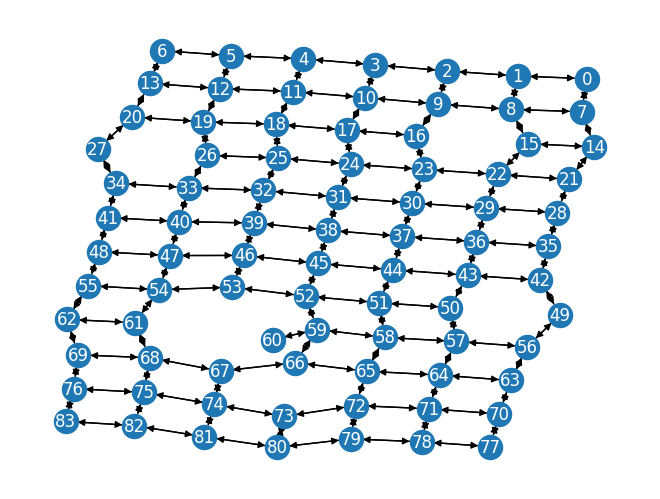

In [11]:
# set up the Rigetti Ankaa-2 device
rigetti = AwsDevice(Devices.Rigetti.Ankaa2)

# access and visualize the device topology
# note that device topology can change day-to-day based on edge fidelity data
print(rigetti.properties.paradigm.connectivity.connectivityGraph)
nx.draw_kamada_kawai(rigetti.topology_graph, with_labels=True, font_color="white")

From the connectivity graph, you can see that qubits 11, 10, and 17 are connected in a line, and with the code in the next cell you can access their respective 2-qubit gate fidelities to make sure you have selected a high-quality qubit subset. 

In [12]:
print(rigetti.properties.provider.specs["2Q"]["10-11"])
print(rigetti.properties.provider.specs["2Q"]["10-17"])

{'fISWAP': 0.9608092769094925, 'fISWAP_std_err': 0.006832379421744852}
{'fISWAP': 0.9175335256563664, 'fISWAP_std_err': 0.014230349601250074}


<div class="alert alert-block alert-info">
    <b>Note:</b> At the time when you run this notebook the fidelity numbers may be different as QPU devices are periodically recalibrated
</div>

After selecting the qubits and validating their gate fidelities, you can now construct a circuit and run it. 

In [13]:
circ = Circuit().iswap(10, 11).iswap(10, 17).rx(10, pi).iswap(10, 11)
verbatim_circ = Circuit().add_verbatim_box(circ)
print(verbatim_circ)

T   : │        0        │    1    │    2    │     3      │    4    │       5       │
                         ┌───────┐ ┌───────┐ ┌──────────┐ ┌───────┐                 
q10 : ───StartVerbatim───┤ ISWAP ├─┤ ISWAP ├─┤ Rx(3.14) ├─┤ ISWAP ├───EndVerbatim───
               ║         └───┬───┘ └───┬───┘ └──────────┘ └───┬───┘        ║        
               ║         ┌───┴───┐     │                  ┌───┴───┐        ║        
q11 : ─────────║─────────┤ ISWAP ├─────┼──────────────────┤ ISWAP ├────────║────────
               ║         └───────┘     │                  └───────┘        ║        
               ║                   ┌───┴───┐                               ║        
q17 : ─────────╨───────────────────┤ ISWAP ├───────────────────────────────╨────────
                                   └───────┘                                        
T   : │        0        │    1    │    2    │     3      │    4    │       5       │


In [14]:
result = rigetti.run(verbatim_circ, shots=1000, disable_qubit_rewiring=True).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[3]
PRAGMA PRESERVE_BLOCK
ISWAP 10 11
ISWAP 10 17
RX(3.141592653589793) 10
ISWAP 10 11
PRAGMA END_PRESERVE_BLOCK
MEASURE 10 ro[0]
MEASURE 11 ro[1]
MEASURE 17 ro[2]
Counter({'010': 632, '011': 105, '000': 103, '110': 61, '100': 47, '111': 24, '101': 14, '001': 14})


As expected, the program is faithfully executed exactly as it was defined.

### Defining verbatim subcircuits 

In some situations, you might only be interested in executing parts of your circuits verbatim, and have the compiler nativize and optimize the rest. The next example demonstrates how to do this. Let's get started by defining the subcircuit we want to execute verbatim.

In [15]:
verbatim_subcirc = Circuit().rx(10, pi).rx(10, pi)

Next, define the part of the circuit you want to compiler to process, so you don't have to worry about nativizing gates. 

In [16]:
subcirc1 = Circuit().cnot(10, 11).cnot(10, 17)
subcirc2 = Circuit().cnot(10, 17).cnot(10, 11)

Finally, put everything together

In [17]:
circ = subcirc1.add_verbatim_box(verbatim_subcirc).add_circuit(subcirc2)
print(circ)

T   : │  0  │  1  │        2        │     3      │     4      │       5       │  6  │  7  │
                                     ┌──────────┐ ┌──────────┐                             
q10 : ───●─────●─────StartVerbatim───┤ Rx(3.14) ├─┤ Rx(3.14) ├───EndVerbatim─────●─────●───
         │     │           ║         └──────────┘ └──────────┘        ║          │     │   
       ┌─┴─┐   │           ║                                          ║          │   ┌─┴─┐ 
q11 : ─┤ X ├───┼───────────║──────────────────────────────────────────║──────────┼───┤ X ├─
       └───┘   │           ║                                          ║          │   └───┘ 
             ┌─┴─┐         ║                                          ║        ┌─┴─┐       
q17 : ───────┤ X ├─────────╨──────────────────────────────────────────╨────────┤ X ├───────
             └───┘                                                             └───┘       
T   : │  0  │  1  │        2        │     3      │     4      │       5       │ 

In [18]:
result = rigetti.run(circ, shots=1000, disable_qubit_rewiring=True).result()
compiled_program = result.additional_metadata.rigettiMetadata.compiledProgram
print(compiled_program)
print(result.measurement_counts)

PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[3]
PRAGMA PRESERVE_BLOCK
RX(1.5707963267948966) 10
RZ(4.71238898038469) 10
ISWAP 10 11
RZ(1.5707963267948966) 10
RZ(3.141592653589793) 11
ISWAP 10 17
RX(1.5707963267948966) 11
RZ(1.5707963267948966) 10
RX(1.5707963267948966) 10
RZ(4.71238898038469) 10
ISWAP 10 17
RX(3.141592653589793) 10
RX(3.141592653589793) 10
RZ(3.141592653589793) 17
RZ(1.5707963267948966) 10
RX(1.5707963267948966) 17
ISWAP 10 17
RZ(1.5707963267948966) 10
RX(1.5707963267948966) 10
RZ(4.71238898038469) 10
ISWAP 10 17
RZ(1.5707963267948966) 10
RZ(3.141592653589793) 17
ISWAP 10 11
RX(1.5707963267948966) 17
RZ(1.5707963267948966) 10
RX(1.5707963267948966) 10
RZ(4.71238898038469) 10
ISWAP 10 11
RZ(3.141592653589793) 11
RX(1.5707963267948966) 11
PRAGMA END_PRESERVE_BLOCK
MEASURE 17 ro[2]
MEASURE 10 ro[0]
MEASURE 11 ro[1]
Counter({'000': 507, '001': 213, '010': 92, '011': 56, '100': 42, '111': 35, '101': 30, '110': 25})


Inspecting the compiled program, you can see that the `cnot` gates were nativized, however, the two `rx` gates in the middle of the circuit remain unaltered, and were not removed by the compiler. 

## Programming verbatim circuits onto the IonQ device

IonQ also supports verbatim compilation. Because qubits in the IonQ device have all-to-all connection, there is no restriction in qubit connectivity; all qubit pairs are available for 2-qubit gates. Because there is no circuit optimization or gate decomposition in verbatim compilation, all gates in the circuit must be native gates. Let's look at IonQ's native gate set.

In [19]:
# set up the IonQ Aria 1 device
ionq_device = AwsDevice(Devices.IonQ.Aria1)

# list the native gate set
print("The native gates for the", ionq_device.name, "device are:")
for gate in ionq_device.properties.paradigm.nativeGateSet:
    print(gate)

The native gates for the Aria 1 device are:
GPI
GPI2
MS


In `device.property`, you can see `fullyConnected=True`, showing that qubits are fully connected. This manifests as the device having a complete topology graph.

fullyConnected=True connectivityGraph={}


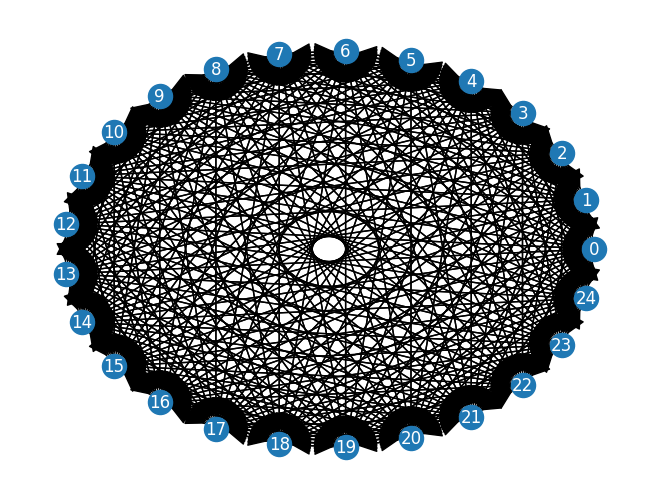

In [20]:
# access and visualize the device topology
print(ionq_device.properties.paradigm.connectivity)
nx.draw_kamada_kawai(
    ionq_device.topology_graph, with_labels=True, font_color="white", arrows=True, arrowsize=30
)

With this information, you can write a circuit to run verbatim on an IonQ device. IonQ currently only supports verbatim compilation for the entire circuit, so every instruction in the circuit will need to be enclosed in a verbatim box. In other words, you cannot have any gates outside of the verbatim box. As well, note that IonQ native gates cannot be used outside of a verbatim box. To learn more about IonQ native gates and the best practice of using them, see the [Amazon Braket Developer Guide](https://docs.aws.amazon.com/braket/latest/developerguide/braket-devices.html?tag=local002-20#braket-qpu-partner-ionq) and [IonQ's documentation page](https://ionq.com/docs/getting-started-with-native-gates). 

In [21]:
circ = Circuit().gpi(0, pi).ms(0, 1, 0.1, 0.2, 0.3)
verbatim_circ = Circuit().add_verbatim_box(circ)
print(verbatim_circ)

T  : │        0        │      1      │           2            │       3       │
                        ┌───────────┐ ┌──────────────────────┐                 
q0 : ───StartVerbatim───┤ GPi(3.14) ├─┤ MS(0.10, 0.20, 0.30) ├───EndVerbatim───
              ║         └───────────┘ └──────────┬───────────┘        ║        
              ║                       ┌──────────┴───────────┐        ║        
q1 : ─────────╨───────────────────────┤ MS(0.10, 0.20, 0.30) ├────────╨────────
                                      └──────────────────────┘                 
T  : │        0        │      1      │           2            │       3       │


In [22]:
task = ionq_device.run(verbatim_circ, shots=10)
print(task.result().measurement_counts)

Counter({'10': 10})


## Programming verbatim circuits onto the IQM device

The native gates of IQM Garnet are PRx and CZ. Use these gates in verbatim circuits when submiting to IQM Garnet. 

In [23]:
# set up the IQM Garnet device
iqm_device = AwsDevice(Devices.IQM.Garnet)

# list the native gate set
print("The native gates for the", iqm_device.name, "device are:")
for gate in iqm_device.properties.paradigm.nativeGateSet:
    print(gate)

The native gates for the Garnet device are:
cz
prx


The native gates need to be programmed on the physical edegs of the device. Let's take a look at the topology of IQM Garnet, shown in the figure below. The topology is a square lattice. The edges are bi-directional where a two-qubit gate can apply on (i,j) and (j,i) where i and j are indices of two qubits. 

fullyConnected=False connectivityGraph={'1': ['2', '4'], '10': ['11', '15', '5', '9'], '11': ['12', '16', '6'], '12': ['17', '7'], '13': ['14', '8'], '14': ['15', '18', '9'], '15': ['16', '19'], '16': ['17', '20'], '18': ['19'], '19': ['20'], '2': ['5'], '3': ['4', '8'], '4': ['5', '9'], '5': ['6'], '6': ['7'], '8': ['9']}


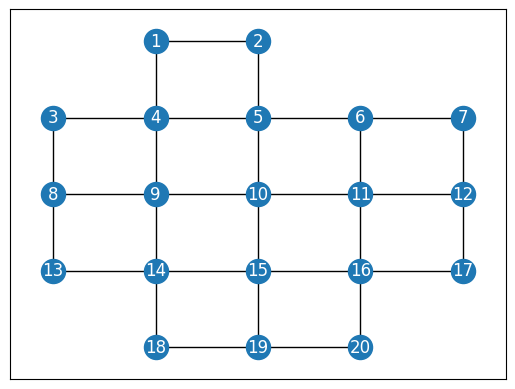

In [24]:
# access and visualize the device topology
print(iqm_device.properties.paradigm.connectivity)

nx.draw_networkx(
    iqm_device.topology_graph,
    pos={
        1: (-1, 2),
        2: (0, 2),
        3: (-2, 1),
        4: (-1, 1),
        5: (0, 1),
        6: (1, 1),
        7: (2, 1),
        8: (-2, 0),
        9: (-1, 0),
        10: (0, 0),
        11: (1, 0),
        12: (2, 0),
        13: (-2, -1),
        14: (-1, -1),
        15: (0, -1),
        16: (1, -1),
        17: (2, -1),
        18: (-1, -2),
        19: (0, -2),
        20: (1, -2),
    },
    arrows=False,
    with_labels=True,
    font_color="white",
)

Now, let's compose a verbatim circuit to IQM Garnet. The circuit below creates a Bell state. With verbatim compilation, you have control in preparing a quantum state. There is no gate optimization and you can experiment with different ways to create the quantum state.

In [25]:
circ = Circuit().prx(1, pi / 2, 0).prx(2, pi / 2, 0).cz(1, 2).prx(2, -pi * 0.5, 0)
verbatim_circ = Circuit().add_verbatim_box(circ)
print(verbatim_circ)

T  : │        0        │       1        │  2  │        3        │       4       │
                        ┌──────────────┐                                         
q1 : ───StartVerbatim───┤ PRx(1.57, 0) ├───●───────────────────────EndVerbatim───
              ║         └──────────────┘   │                            ║        
              ║         ┌──────────────┐ ┌─┴─┐ ┌───────────────┐        ║        
q2 : ─────────╨─────────┤ PRx(1.57, 0) ├─┤ Z ├─┤ PRx(-1.57, 0) ├────────╨────────
                        └──────────────┘ └───┘ └───────────────┘                 
T  : │        0        │       1        │  2  │        3        │       4       │


## Conclusion 
This notebook introduced the basic functionality of verbatim compilation of Amazon Braket, that allows you to run circuits or subcircuits to be executed exactly as defined without any compiler modifications. You can find further information in the [Amazon Braket documentation](https://docs.aws.amazon.com/braket/). 

In [26]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2)."
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD"
)

Quantum Task Summary
{<_Rigetti.Ankaa2: 'arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2'>: {'shots': 5000, 'tasks': {'COMPLETED': 5}}, <_IonQ.Aria1: 'arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1'>: {'shots': 10, 'tasks': {'COMPLETED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 6.600 USD
